In [1]:
# data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()

# machine learning
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

# keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.layer_utils import print_summary

# tqdm
from tqdm import tqdm_notebook as tqdm

np.random.seed(7)
tf.set_random_seed(777)  # reproducibility

#miscellaneous
import random
import os, gc
import warnings
warnings.filterwarnings('ignore')
import operator
import json
from pprint import pprint
from xml.etree.ElementTree import parse
import datetime
import re
import math
import requests

Using TensorFlow backend.


In [2]:
# utility functions
def getTimeStamp(fileName):
    startDate = fileName.split('.')[0][:4]
    endDate = fileName.split('.')[0][4:8]
    
    return datetime.datetime.strptime(startDate, timeformat)

In [3]:
dam_df = pd.read_json('data/damInfo.json', orient='records')
dam_df = dam_df.replace('', 'null')
cols = ['dmobscd', 'obsnm', 'agcnm', 'addr', 'etcaddr', 'lon', 'lat', 'pfh', 'fldlmtwl']
dam_df = dam_df[cols]

In [23]:
def dam_data_load(damDir, startYM, endYM, columns=['dmobscd', 'ymdhm', 'swl','inf', 'sfw', 'ecpc', 'tototf']):
    timeformat = '%y%m'
    res_df = pd.DataFrame(columns=columns)
    damFiles = sorted([name for name in os.listdir(damDir) if os.path.isfile(os.path.join(damDir, name))], key=getTimeStamp)
    
    startYM = datetime.datetime.strptime(startYM, timeformat)
    endYM = datetime.datetime.strptime(endYM, timeformat)
    
    for file in damFiles:
        fileStartYM = datetime.datetime.strptime(file.split('.')[0][:4], timeformat)
        fileEndYM = datetime.datetime.strptime(file.split('.')[0][4:8], timeformat)
        
        if (startYM <= fileStartYM and fileEndYM <= endYM):
            fileName = damDir + file
            file_df = pd.read_json(damDir + file, orient='records')
            file_df = file_df.reindex(index=file_df.index[::-1])
            res_df = pd.concat([res_df, file_df]).reset_index(drop=True)
        
    res_df.drop_duplicates(subset=['ymdhm'], keep=False)
    
    return res_df

def dam_data_make(damInfo, damData, mergeCols=['dmobscd', 'pfh', 'fldlmtwl']):
    merge_df = pd.merge(damData, damInfo[mergeCols], on='dmobscd')
    
    # drop unnecessary columns
    merge_df = merge_df.drop(['dmobscd', 'sfw'], axis=1)
    
    # make new columns
    #merge_df['fldlmtwl'] = merge_df['fldlmtwl'].astype(float)
    #merge_df['isOverFLDLMTWL'] = merge_df.apply(lambda row : 1 if row.swl > row.fldlmtwl else 0, axis=1)

    # drop columns that already used
    merge_df = merge_df.drop(['pfh', 'fldlmtwl'], axis=1)
    
    # drop outliers
    merge_df = merge_df.drop(merge_df[merge_df['swl'] < 10].index, axis=0)

    #cols = ['ymdhm', 'swl', 'inf', 'ecpc', 'tototf', 'isOverFLDLMTWL']
    cols = ['swl', 'inf', 'ecpc', 'tototf']
    
    
    return merge_df[cols]

def build_dataset(DIR):
    return dam_data_make(dam_df, dam_data_load(DIR, '1607', '1709'))

def create_dataset(dataset, colNum, lookBack):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - lookBack - 1):
        a = dataset[i:(i + lookBack)].values
        dataX.append(a)
        b = dataset[i + lookBack: i + lookBack + 1].values
        dataY.append(b)
        
    return np.array(dataX).reshape((-1, colNum)), np.array(dataY).reshape((-1, colNum))

def make_train_test(dataset, size, lookBack):
    train_size = int(len(dataset) * size)
    test_size = len(dataset) - train_size
    
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    
    trainX, trainY = create_dataset(train, 4, lookBack)
    testX, testY = create_dataset(test, 4, lookBack)
    
    return trainX, trainY, testX, testY

def data_scaling_and_reshaping(trainX, trainY, testX, testY, scaler, lookBack):
    trainX = scaler.fit_transform(trainX)
    trainY, testX, testY = scaler.transform(trainY), scaler.transform(testX), scaler.transform(testY)
    
    return np.reshape(trainX, (-1, lookBack, trainX.shape[1])), trainY, np.reshape(testX, (-1, lookBack, testX.shape[1])), testY, scaler

In [39]:
def build_model(lookBack):
    model = Sequential()
    model.add(LSTM(16, input_shape=(lookBack, 4)))
    model.add(Dense(4))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def predict(model, trainX, testX, scaler):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    
    return trainPredict, testPredict

def inverse_Ydata(trainY, testY, scaler):
    trainY = scaler.inverse_transform(trainY)
    testY = scaler.inverse_transform(testY)
    
    return trainY, testY

def print_score(trainPredict, trainY, testPredict, testY):
    trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:, 0]))
    testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))

In [46]:
def make_final_plot(dataset, trainPredict, testPredict, lookBack, target='swl', targetIndex=0):
    trainPredictPlot = np.empty_like(dataset[target])
    trainPredictPlot[:] = np.nan
    trainPredictPlot[lookBack:len(trainPredict[:, targetIndex]) + lookBack] = trainPredict[:, targetIndex]
    
    testPredictPlot = np.empty_like(dataset[target])
    testPredictPlot[:] = np.nan
    #testPredictPlot[len(trainPredict[:, targetIndex]) + (lookBack*2) + 1:len(dataset[target]) - 1] = testPredict[:, targetIndex]
    testPredictPlot[len(trainPredict[:, targetIndex]) + (lookBack) + 1:len(dataset[target]) - 1] = testPredict[:, targetIndex]
    
    plt.subplots(1, 1, figsize=(16, 12))
    plt.plot(dataset[target])
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    
    plt.show()
    
def make_various_plot(trainPredict, trainY, testPredict, testY, targetIndex=0):
    trP = pd.Series(trainPredict[:, targetIndex])
    trY = pd.Series(trainY[:, targetIndex])
    teP = pd.Series(testPredict[:, targetIndex])
    teY = pd.Series(testY[:, targetIndex])
    
    f, axes = plt.subplots(2, 2, figsize=(16, 12))
    trP.plot(ax=axes[0, 0], color='red')
    trY.plot(ax=axes[0, 1], color='red')
    teP.plot(ax=axes[1, 0], color='green')
    teY.plot(ax=axes[1, 1], color='green')
    
    plt.show()

In [56]:
# params
lookBack = 1
DIR = 'data/dams/boryeong/'
scaler = MinMaxScaler(feature_range=(0, 1))
timeformat='%y%m'

In [57]:
dataset = build_dataset(DIR)
trainX, trainY, testX, testY = make_train_test(dataset, 0.90, lookBack=1)
trainX, trainY, testX, testY, scaler = data_scaling_and_reshaping(trainX, trainY, testX, testY, scaler)

model = build_model()

In [58]:
model.summary()
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_4 (LSTM)                    (None, 16)            1344        lstm_input_4[0][0]               
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 4)             68          lstm_4[0][0]                     
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/100
3s - loss: 0.0740
Epoch 2/100
2s - loss: 0.0111
Epoch 3/100
2s - loss: 0.0056
Epoch 4/100
2s - loss: 0.0048
Epoch 5/100
2s - loss: 0.0043
Epoch 6/100
2s - loss: 0.0039
Epoch 7/100
2s - loss: 0.0035
Epoch 8/100
2s - loss: 0.0032
Epoch 9/100
2s - loss: 0.0031
Epoch 10/100
2s - loss: 0.0030
Epoch 11/100
2s - loss: 0

In [60]:
trainPredict, testPredict = predict(model, trainX, testX, scaler)
trainY, testY = inverse_Ydata(trainY, testY, scaler)
print_score(trainPredict, trainY, testPredict, testY)

Train Score: 0.14 RMSE
Test Score: 0.21 RMSE


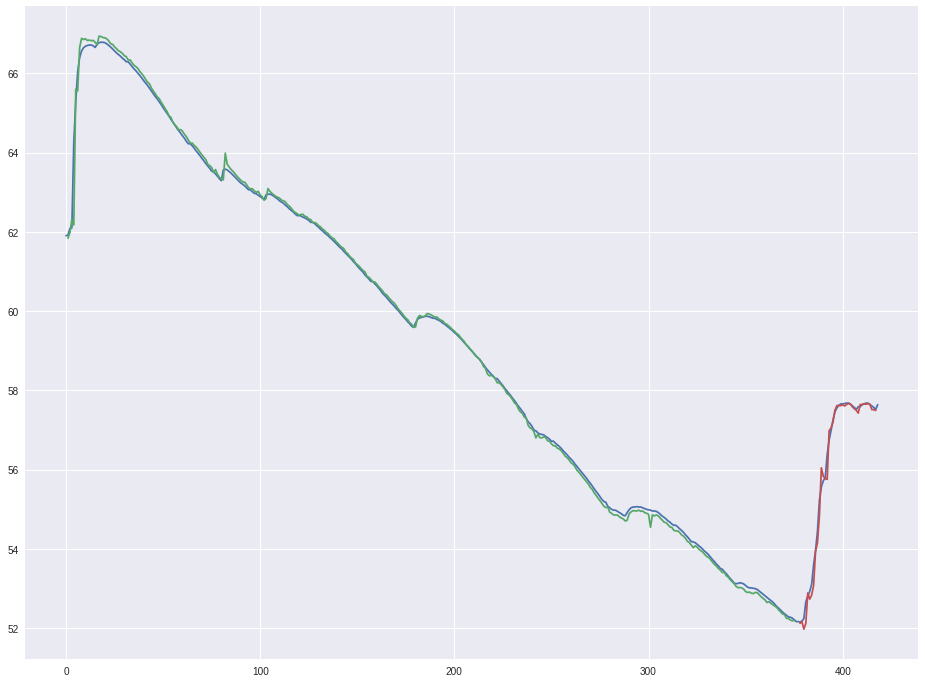

In [62]:
make_final_plot(dataset, trainPredict, testPredict, 1)

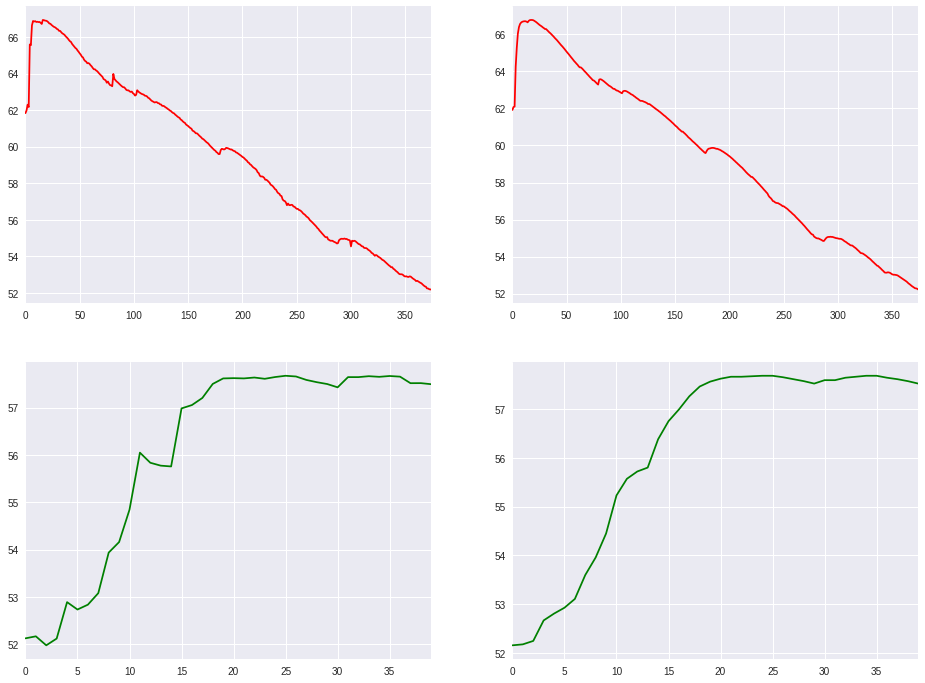

In [63]:
make_various_plot(trainPredict, trainY, testPredict, testY)

In [64]:
# params
lookBack = 1
DIR = 'data/dams/soyanggang/'
scaler = MinMaxScaler(feature_range=(0, 1))
timeformat='%y%m'

In [67]:
dataset = build_dataset(DIR)
trainX, trainY, testX, testY = make_train_test(dataset, 0.90, lookBack=1)
trainX, trainY, testX, testY, scaler = data_scaling_and_reshaping(trainX, trainY, testX, testY, scaler)

model = build_model()
model.summary()
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

trainPredict, testPredict = predict(model, trainX, testX, scaler)
trainY, testY = inverse_Ydata(trainY, testY, scaler)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_6 (LSTM)                    (None, 16)            1344        lstm_input_6[0][0]               
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 4)             68          lstm_6[0][0]                     
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/100
3s - loss: 0.0606
Epoch 2/100
2s - loss: 0.0122
Epoch 3/100
2s - loss: 0.0066
Epoch 4/100
2s - loss: 0.0048
Epoch 5/100
2s - loss: 0.0035
Epoch 6/100
2s - loss: 0.0027
Epoch 7/100
2s - loss: 0.0024
Epoch 8/100
2s - loss: 0.0023
Epoch 9/100
2s - loss: 0.0023
Epoch 10/100
2s - loss: 0.0022
Epoch 11/100
2s - loss: 0

In [ ]:
print_score(trainPredict, trainY, testPredict, testY)

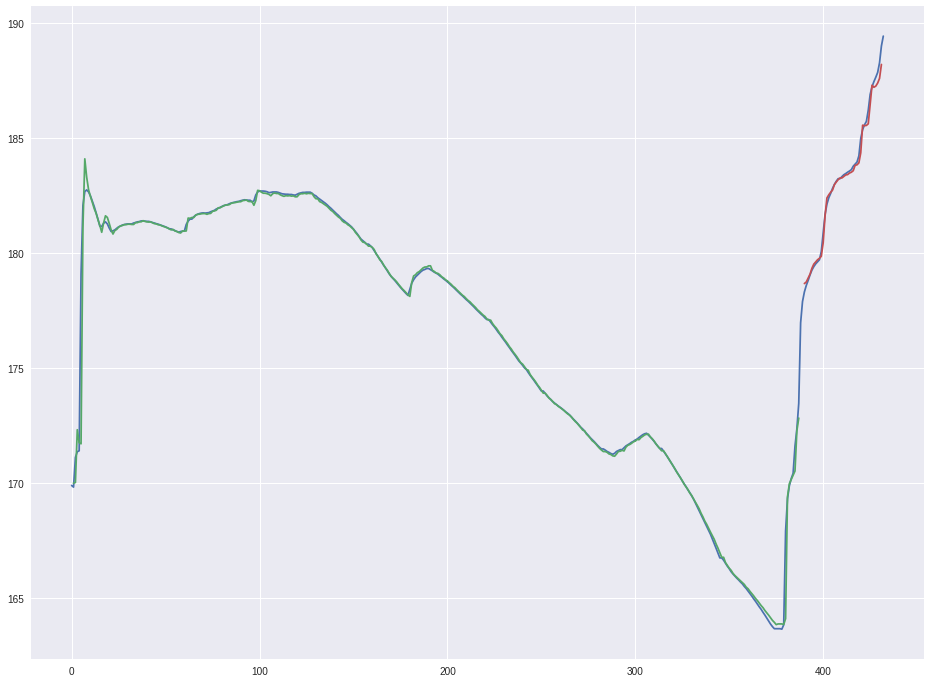

In [69]:
make_final_plot(dataset, trainPredict, testPredict, 1)

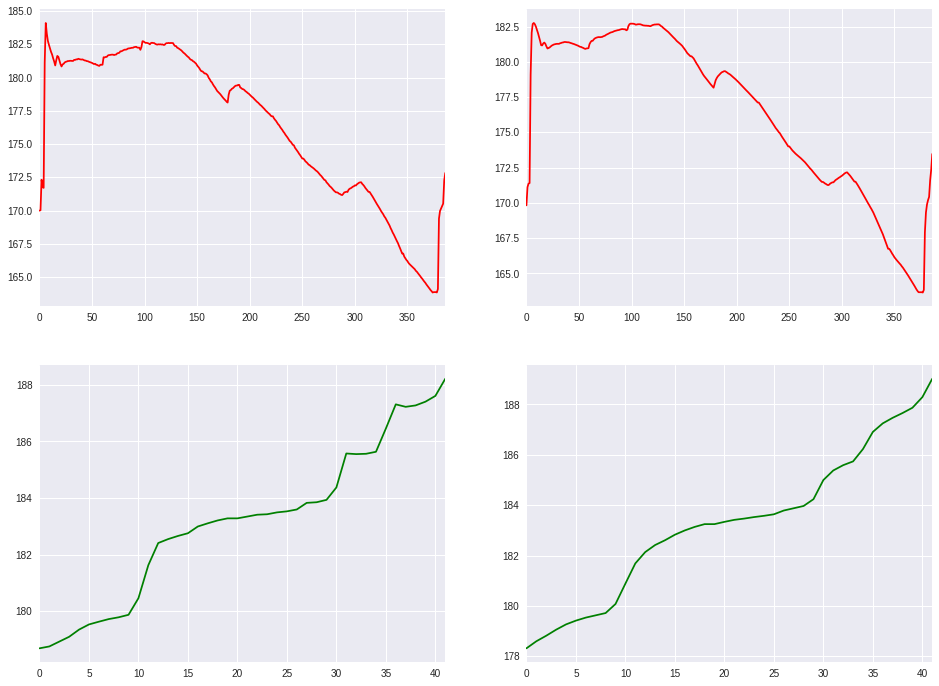

In [70]:
make_various_plot(trainPredict, trainY, testPredict, testY)

In [71]:
dataset

,swl,inf,ecpc,tototf
0,169.90,8.8,1465.05,120.6
1,169.83,85.7,1467.75,112.4
2,171.12,687.2,1417.40,104.4
3,171.37,219.4,1407.46,104.4
4,171.41,136.0,1405.87,117.5
5,179.09,3918.5,1071.33,46.6
6,182.08,1716.2,924.39,15.5
7,182.69,483.2,893.42,124.7
8,182.76,255.7,889.84,214.3
9,182.67,160.6,894.44,213.8


In [10]:
# params
lookBack = 2
DIR = 'data/dams/soyanggang/'
scaler = MinMaxScaler(feature_range=(0, 1))
timeformat='%y%m'

In [29]:
dataset = build_dataset(DIR)
trainX, trainY, testX, testY = make_train_test(dataset, 0.90, lookBack)
trainX, trainY, testX, testY, scaler = data_scaling_and_reshaping(trainX, trainY, testX, testY, scaler, lookBack)

model = build_model(lookBack)
model.summary()
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4s - loss: 0.0728
Epoch 2/100
2s - loss: 0.0116
Epoch 3/100
2s - loss: 0.0045
Epoch 4/100
2s - loss: 0.0031
Epoch 5/100
2s - loss: 0.0025
Epoch 6/100
2s - loss: 0.0023
Epoch 7/100
2s - loss: 0.0023
Epoch 8/100
2s - loss: 0.0022
Epoch 9/100
2s - loss: 0.0022
Epoch 10/100
2s - loss: 0.0022
Epoch 11/100
2s - loss: 0.0022
Epoch 12/100
2s - loss: 0.0022
Epoch 13/100
2s - loss: 0.0022
Epoch 14/100
2s - loss: 0.0022
Epoch 15/100
2s - loss: 0.0022
Epoch 16/100
2s - loss: 0.0022
Epoch 17/100
2s - loss: 0.0022
Epoch 18/100
2s - 

NameError: name 'inverse_Ydata' is not defined

In [40]:
trainPredict, testPredict = predict(model, trainX, testX, scaler)
trainY, testY = inverse_Ydata(trainY, testY, scaler)

In [43]:
print_score(trainPredict, trainY, testPredict, testY)

Train Score: 0.46 RMSE
Test Score: 0.38 RMSE


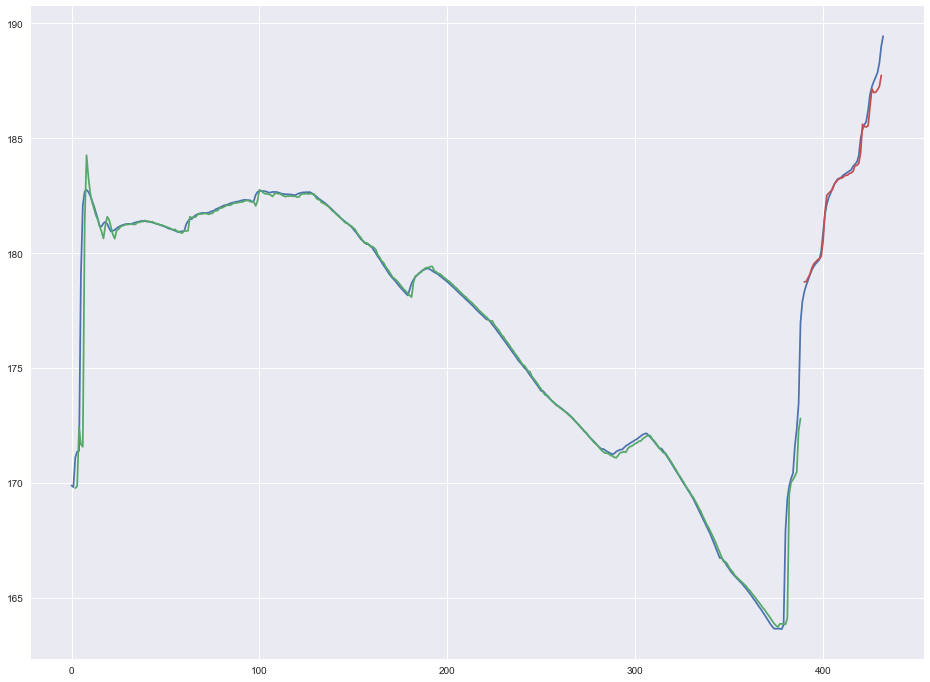

In [47]:
make_final_plot(dataset, trainPredict, testPredict, 2)

In [45]:
len(testPredict)

42